# Camera Calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


# generate the object points and image points using the calibration images
def find_image_points(nx,ny,objpoints,imgpoints):
    # prepare the object points like (0,0,0), (1,0,0)
    objp=np.zeros((nx*ny,3),np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    # iterate through all the images
    for fname in images:
        # read the image
        img = cv2.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # If found, draw corners
        if ret == True:
            # Draw the chessboard corners and add the object points and image points (corners) to the list
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            #plt.imshow(img)

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
objpoints= []
imgpoints= []
find_image_points(nx,ny,objpoints,imgpoints)

# Distortion Correction

In [2]:
# returns the undistorted image 
def cal_undistort(img, objpoints, imgpoints):
    # convert the image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # calibrate the camera using the image points and object points and returns the camera matrix and coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # undistort the image using the camera matrix and coefficients
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist,mtx, dist



# Distortion Corrected Image

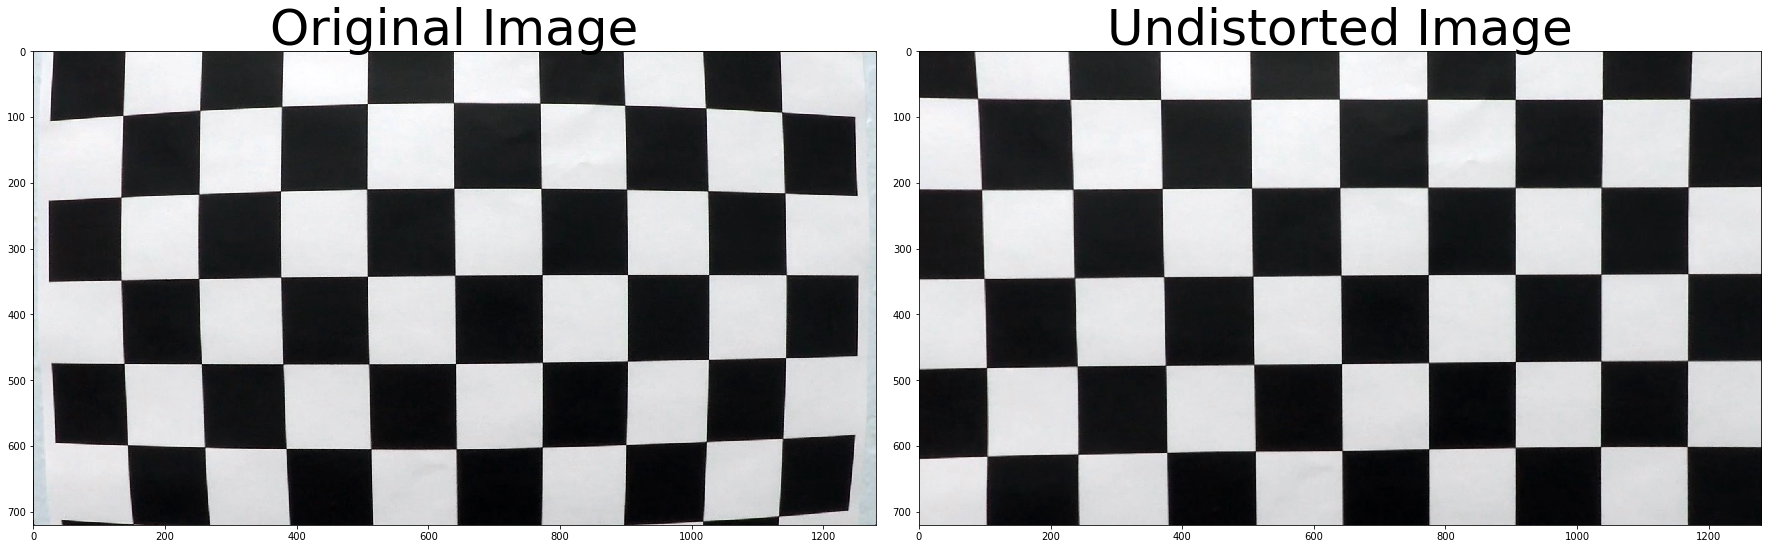

In [3]:
img=cv2.imread('camera_cal/calibration1.jpg')
undistorted,mtx, dist = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
mpimg.imsave("output_images/calibration1_output.jpg", undistorted)

In [4]:
import os
# then save them to the test_images_output directory.
#files=os.listdir("camera_cal/")
#for file in files:
img = cv2.imread("test_images/test2.jpg")
undistorted,mtx, dist = cal_undistort(img, objpoints, imgpoints)
mpimg.imsave("output_images/test2_undistorted.jpg", undistorted)

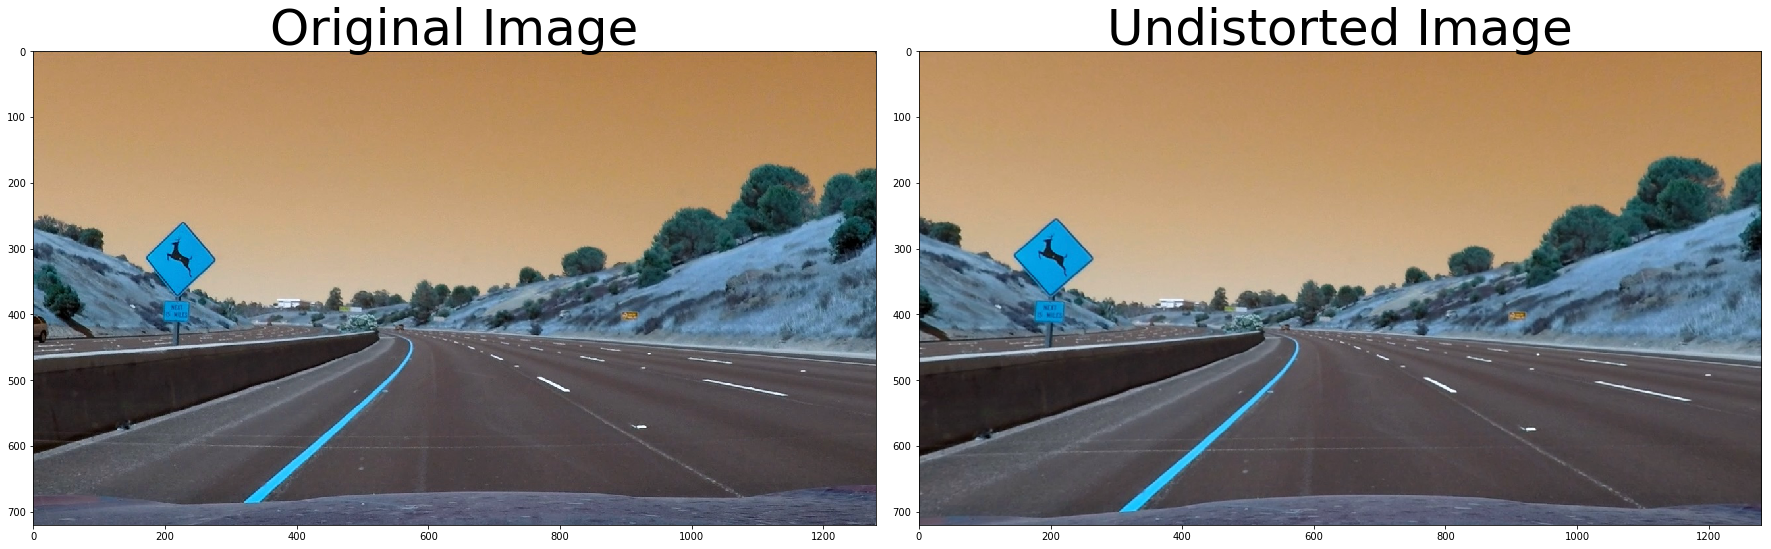

In [5]:
img=cv2.imread('test_images/test2.jpg')
undistorted,mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
mpimg.imsave("output_images/test2_undistorted.jpg", undistorted)

In [6]:
# returns the combined color threshold and gradient threshold
def getColorThresholdBinary(img, s_thresh=(170, 255), sx_thresh=(20, 150)):
    img = np.copy(img)
    # Convert to HLS color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # compute the Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # compute the Sobel y
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1) # Take the derivative in y
    #sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute y derivative
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Threshold y gradient
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= sx_thresh[0]) & (scaled_sobely <= sx_thresh[1])] = 1
    
    # calculate the direction of the gradient 
    dir_sobel=np.arctan2(abs_sobely,abs_sobelx)
    dir_binary=np.zeros_like(dir_sobel)
    # Apply the threshold
    dir_binary[(0.7<=dir_sobel) & (dir_sobel<=1.3)]=1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1 # apply the threshold
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | ((sxbinary == 1) & (sybinary == 1) & (dir_binary==1))] = 1
    return combined_binary



# Threshold Binary Image

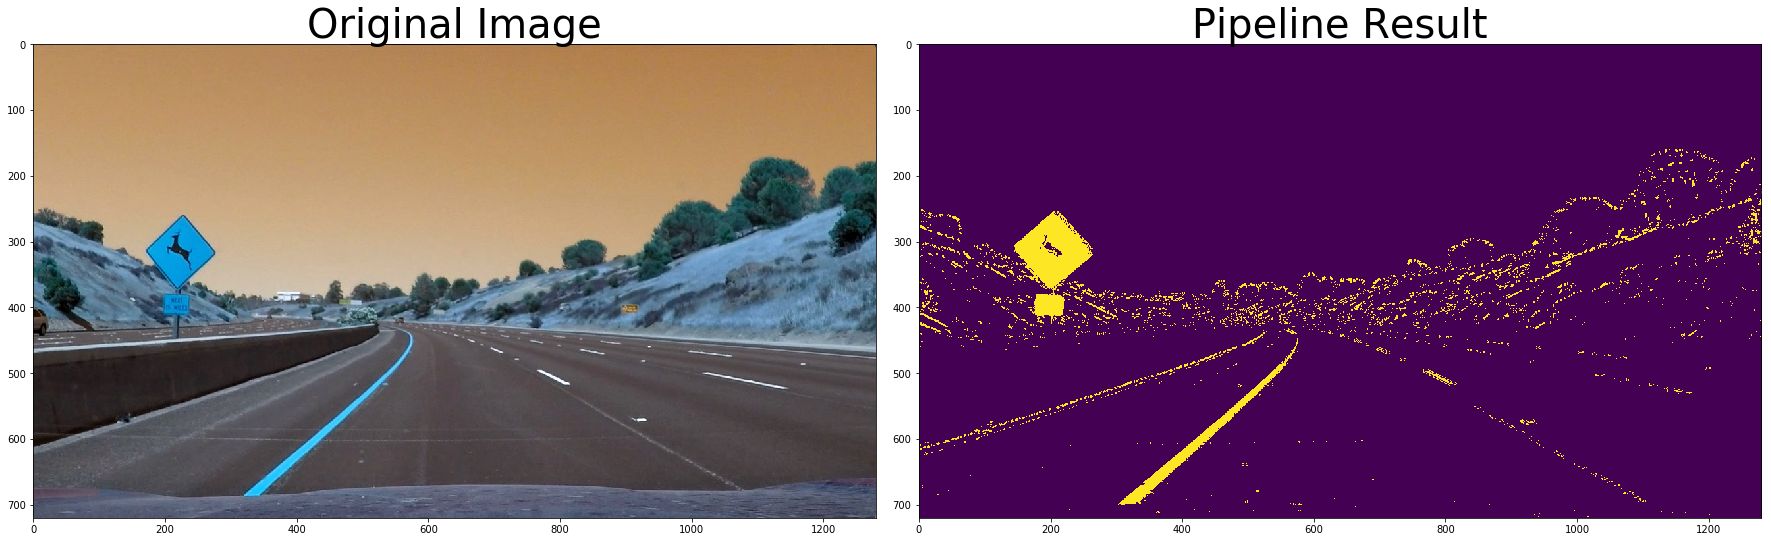

In [7]:
img=cv2.imread('test_images/test2.jpg')
undistorted,mtx, dist = cal_undistort(img, objpoints, imgpoints)
# get the combined color threshold and gradient threshold
color_grad_img = getColorThresholdBinary(undistorted)
mpimg.imsave("output_images/test2_binary_threshold.jpg", color_grad_img)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_grad_img)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Perspective Transform

In [8]:
# returns the warped image
def perspectiveTransform(img):
    # set the values of axis in the region of interest
    y1_left=y2_right=720
    y2_left=y1_right=455
    x1_left=190
    x2_left=585
    x1_right=705
    x2_right=1130
    src = np.float32([[x2_left,y2_left],[x1_right,y1_right],[x2_right,y2_right],[x1_left,y1_left]])
    offset = 200  # set an offset value
    img_size=(img.shape[1], img.shape[0]) # get the image shape
    dst = np.float32([
        [offset, 0],
        [img_size[0]-offset, 0],
        [img_size[0]-offset, img_size[1]], 
        [offset, img_size[1]]
    ])
    # Using the src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    #plt.imshow(warped)
    return warped,src,dst



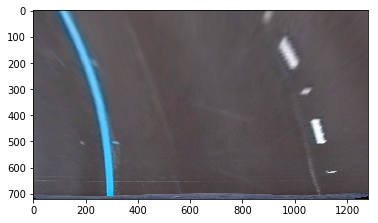

In [9]:
# read the image
img=cv2.imread('test_images/test2.jpg')
# get the warped image
warped,src,dst=perspectiveTransform(img)
mpimg.imsave("output_images/test2_perspectiveTransform.jpg", warped)
#plot the warped image
plt.imshow(warped)

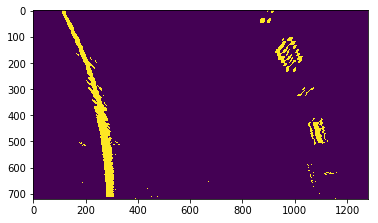

In [10]:
# read the image
img=cv2.imread('test_images/test2.jpg')
undistorted,mtx, dist = cal_undistort(img, objpoints, imgpoints)
# get the combined color threshold and gradient threshold
color_grad_img = getColorThresholdBinary(undistorted)
# get the warped image
warped,src,dst=perspectiveTransform(color_grad_img)
#plot the warped image
plt.imshow(warped)

In [11]:
# class to represent the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

# Fit Polynomial with identified lane pixels

In [12]:
# returns the lane pixels of left and right lane
def get_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # middle of the image
    midpoint = np.int(histogram.shape[0]//2)
    # peak of the left and right halves of the histogram denotes the starting of the lanes
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # set the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window.
    minpix = 50

    # Set the height of windows.
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # iterate through the windows in both left and right lane
    for window in range(nwindows):
        # y values of the windows in both left and right lane will be same
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        #compute the x values of the window boundaries using the margin
        win_xleft_low = leftx_current-margin  
        win_xleft_high = leftx_current+margin   
        win_xright_low =  rightx_current-margin 
        win_xright_high = rightx_current+margin 
        
        # Now get the nonzero pixels identified in the window region in both the lanes
        good_left_inds = ((win_xleft_low <= nonzerox) & (nonzerox< win_xleft_high) &
        (nonzeroy<win_y_high) &((win_y_low <= nonzeroy))).nonzero()[0]
        good_right_inds = ((win_xright_low <= nonzerox) & (nonzerox< win_xright_high) &
        (nonzeroy<win_y_high) &((win_y_low <= nonzeroy))).nonzero()[0]
        
        # Append these indices to the left lane and right lane indices list
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # if the pixels in the window are found to be less than minimum pixels then recentre the window using mean of pixels in the window 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices to get a single list
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def detect_lane(binary_warped):
    # get the lane pixels
    leftx, lefty, rightx, righty, out_img = get_lane_pixels(binary_warped)
    
    # fit the polynomial with x and y values to get the coefficients
    left_fit = np.polyfit(lefty,leftx,2,rcond=None, full=False, w=None, cov=False)
    right_fit = np.polyfit(righty,rightx,2,rcond=None, full=False, w=None, cov=False)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    return out_img


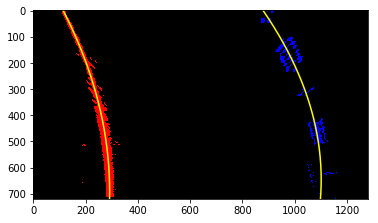

In [13]:
# read the image
img=cv2.imread('test_images/test2.jpg')
undistorted,mtx, dist = cal_undistort(img, objpoints, imgpoints)
# get the combined color threshold and gradient threshold
color_grad_img = getColorThresholdBinary(undistorted)
# get the warped image
binary_warped,src,dst=perspectiveTransform(color_grad_img)
out_img = detect_lane(binary_warped)
plt.imshow(out_img)
plt.savefig("output_images/test2_fitPolynomial.jpg")

# Quick search in the next frame after the lane detection

In [14]:
# returns the fitted values of x in the left and right lane
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # fit the polynomial with x and y values to get the coefficients
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    return left_fitx, right_fitx, ploty

# returns the x and y pixels in the margin of the previous fitted polynomial.
# will be used if already the lanes were detected in the previous frame.
def effective_search(binary_warped,left_fit,right_fit):
    
    # set the width of the margin around the previous polynomial to search
    margin = 80

    # get the activated pixels on the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # search for the activated pixels in the margin of the polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


# Draw the lane area on the image

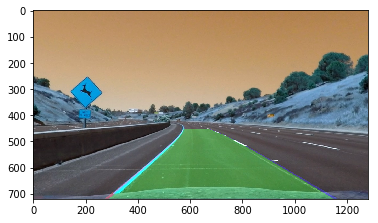

In [15]:
# read the image
img=cv2.imread('test_images/test2.jpg')
undistorted,mtx, dist = cal_undistort(img, objpoints, imgpoints)
# get the combined color threshold and gradient threshold
color_grad_img = getColorThresholdBinary(undistorted)
# get the warped image
# get the binary warped image by applying the perspective Transform
binary_warped,src,dst=perspectiveTransform(color_grad_img)
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# get the lane pixels on the warped image
leftx, lefty, rightx, righty, out_img = get_lane_pixels(binary_warped)
# fit the polynomial on the warped image
left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
# draw the lines on the fitted x and y values
cv2.polylines(color_warp,  np.int_([pts_left]),  False,  (255, 0, 0),  30)
cv2.polylines(color_warp,  np.int_([pts_right]),  False,  (0, 0, 255),  30)
# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
# calculate the inverse perspective Transform
Minv = cv2.getPerspectiveTransform(dst, src)
# use the transform coefficients to get the original image
newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0]))
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
mpimg.imsave("output_images/test2_lanesDrawn.jpg", result)
plt.imshow(result)

# Calculate the radius of the curvature of the lane

In [16]:
# returns the left and right curvature radius
def measure_curvature_real(leftx, lefty, rightx, righty ,ploty):
    # conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # fit the polynomial in real world space by converting the pixels in meters
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # max y-value (bottom of the image) where we want radius of curvature
    y_eval = np.max(ploty)
    # compute the radis of curvature for the left and right lane
    left_curverad= ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad= ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad


# Pipeline

In [17]:
from statistics import mean
from operator import add
# define the left and right lane
left_line=Line()
right_line=Line()
# returns the processed image with lane drawn onto it
def process(img):
    # get the undistorted image
    undistorted,mtx, dist = cal_undistort(img, objpoints, imgpoints)
    # get the binary image with color threshold and gradient threshold
    color_grad_img = getColorThresholdBinary(undistorted)
    # get the binary warped image using perspectibe transform
    binary_warped,src,dst=perspectiveTransform(color_grad_img)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # if left lane and right lanes are not detected then use window technique to detect the lanes
    if(left_line.detected is False or right_line.detected is False):
        # get the x and y pixels of the lanes
        leftx, lefty, rightx, righty, out_img = get_lane_pixels(binary_warped)
        # fit the line on the x and y pixels
        left_fit = np.polyfit(lefty,leftx,2,rcond=None, full=False, w=None, cov=False)
        right_fit = np.polyfit(righty,rightx,2,rcond=None, full=False, w=None, cov=False)
        # returns the fitted values of x in the left and right lane
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        left_line.detected=True
        right_line.detected=True
        # add the fitted values of x in the left and right lane
        left_line.recent_xfitted.append(left_fitx)
        right_line.recent_xfitted.append(right_fitx)
        # average value of x of the fitted lines over last n fits
        left_line.bestx=left_fitx # lane is detected for the first time
        right_line.bestx=right_fitx
        # average polynomial coefficients over last n fits
        left_line.best_fit=left_fit
        right_line.best_fit=right_fit
        # polynomial coefficients for the most recent fit
        left_line.current_fit=np.array([left_fit])
        right_line.current_fit=np.array([right_fit])
        # radius of curvature of the left and right lane
        left_line.radius_of_curvature,right_line.radius_of_curvature=measure_curvature_real(leftx, lefty, rightx, righty,ploty)
        # left line position 
        left_line.line_base_pos=left_fitx[-1]*xm_per_pix
        # right line position
        right_line.line_base_pos=right_fitx[-1]*xm_per_pix  
    else:
        # if line was detected in the last frame, we need to search around the previous fitted poynomial
        # use the best line fit to search. best line fit is the average of polynomial coefficients over last n frames.
        leftx, lefty, rightx, righty=effective_search(binary_warped,left_line.best_fit,right_line.best_fit)
        # fit the line on the x and y pixels in the margin of previous fitted poynomial
        left_fit = np.polyfit(lefty,leftx,2,rcond=None, full=False, w=None, cov=False)
        right_fit = np.polyfit(righty,rightx,2,rcond=None, full=False, w=None, cov=False)
        # returns the fitted values of x in the left and right lane
        left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
        # add the fitted values of x in the left and right lane
        left_line.recent_xfitted.append(left_fitx)
        right_line.recent_xfitted.append(right_fitx)
        # average the value of x of the fitted lines with each new frame
        left_line.bestx=(left_line.bestx+left_fitx)/2
        right_line.bestx=(right_line.bestx+right_fitx)/2
        # average the value of polynomial coefficients of the fitted lines with each new frame
        left_line.best_fit=(left_line.best_fit+left_fit)/2
        right_line.best_fit=(right_line.best_fit+right_fit)/2
        # polynomial coefficients for the most recent fit
        left_line.current_fit=np.array([left_fit])
        right_line.current_fit=np.array([right_fit])
        # radius of curvature of the left and right lane
        left_line.radius_of_curvature,right_line.radius_of_curvature=measure_curvature_real(leftx, lefty, rightx, righty,ploty)
        # left line position 
        left_line.line_base_pos= left_fitx[-1]*xm_per_pix
        # right line position
        right_line.line_base_pos=right_fitx[-1]*xm_per_pix
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # generate y values
    ploty=np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    # use the average value of x of the fitted lines over last n frames as the left and right lane pixel
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # draw the lines 
    cv2.polylines(color_warp,  np.int_([pts_left]),  False,  (255, 0, 0),  50)
    cv2.polylines(color_warp,  np.int_([pts_right]),  False,  (0, 0, 255),  50)
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # calculate the inverse perspective Transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use the transform coefficients to get the original image
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0]))
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    dir=None
    # compute the distance of the vehicle from the centre
    dist_from_centre=(img.shape[1]/2)*xm_per_pix - (right_line.line_base_pos+left_line.line_base_pos)/2
    # average curvature radius of left and right line
    curve_rad=str(int((int(right_line.radius_of_curvature)+int(left_line.radius_of_curvature))/2))
    if(int(curve_rad)>10000):
        curve_rad='inf'
    # if distance computed is positive then vehicle is left side of the centre else right side of the centre
    if(dist_from_centre >0):
        dir='left'
    else:
        dir='right'
    # display the radius and distance from the centre on the image    
    cv2.putText(result,'Radius of Curvature ='+curve_rad+' (m)', (50,50),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2)
    cv2.putText(result,'Vehicle is '+str(abs(round(dist_from_centre,2)))+ ' m '+str(dir)+ ' of centre', (50,150),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),2)
    
    return result


In [18]:
def video_pipeline(vid):
    # Import everything needed to edit/save/watch video clips
    from moviepy.editor import VideoFileClip
    from IPython.display import HTML
    
    clip1 = VideoFileClip("project_video.mp4")
    white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(vid, audio=False)
vid = 'project_video_output.mp4'
video_pipeline(vid)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [14:27<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 11min 20s, sys: 1min 1s, total: 12min 22s
Wall time: 14min 30s
